# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Categorical, Integer
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
95886,18469,2,165,68.0,113,5700,1,1,0,0,1,0
72510,20501,1,167,78.0,130,80,3,3,0,0,1,1
88450,21316,1,155,90.0,120,90,1,1,0,0,1,0
67958,18890,1,158,71.0,100,70,1,1,0,0,1,0
78842,21917,1,169,69.0,140,60,1,1,0,0,1,1
37794,18033,2,169,65.0,120,80,1,1,0,0,0,1
56692,21799,1,160,75.0,145,90,1,1,0,0,1,1
4075,18067,1,162,87.0,110,70,1,1,0,0,1,0
22603,21297,2,166,75.0,140,90,2,2,0,0,0,1


In [3]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
model = RandomForestClassifier(random_state=42)

## BayesSearchCV

In [4]:
start = time()

opt = BayesSearchCV(
    model,
    search_spaces=[
        {"max_depth": Integer(5, 250)},
        {"min_samples_leaf": Integer(1, 50)},
        ({"criterion": Categorical(["gini", "entropy"])}, 64),  # categorical parameter
    ],
    n_iter=512,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc",
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * 2 + 32

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"Best score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 10 == 0:
        print(f"Iteration {iteration}...")


opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt.best_score_:.4f}")
print(f"Test score     : {opt.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt.best_params_.items():
    print(f"\t{item}")

Number of iterations: 1088
Best score (iteration): 0.7733 (1)
Best score (iteration): 0.7975 (8)
Iteration 10...
Iteration 20...
Best score (iteration): 0.7983 (26)
Best score (iteration): 0.7987 (27)
Iteration 30...
Iteration 40...
Iteration 50...
Iteration 60...
Iteration 70...
Iteration 80...
Iteration 90...
Iteration 100...
Iteration 110...
Iteration 120...
Iteration 130...
Iteration 140...
Iteration 150...
Iteration 160...
Iteration 170...
Iteration 180...
Iteration 190...
Iteration 200...
Iteration 210...
Iteration 220...
Iteration 230...
Iteration 240...
Iteration 250...
Iteration 260...
Iteration 270...
Iteration 280...
Iteration 290...
Iteration 300...
Iteration 310...
Iteration 320...
Iteration 330...
Iteration 340...
Iteration 350...
Iteration 360...
Iteration 370...
Iteration 380...
Iteration 390...
Iteration 400...
Iteration 410...
Iteration 420...
Iteration 430...
Iteration 440...
Iteration 450...
Iteration 460...
Iteration 470...
Iteration 480...
Iteration 490...
Iterati

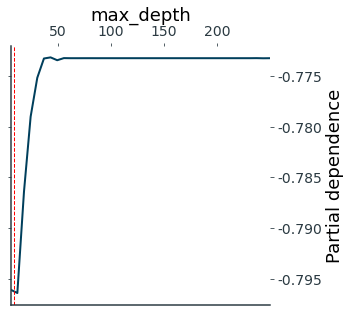

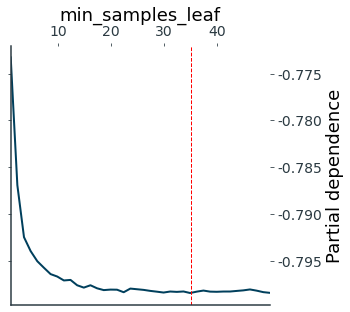

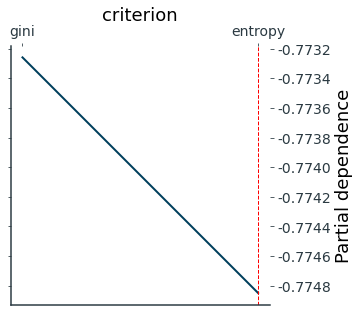

In [24]:
hps = ["max_depth", "min_samples_leaf", "criterion"]
for i in range(3):
    plot_objective(
        opt.optimizer_results_[i],
        dimensions=[hps[i]],
        n_minimum_search=int(1e8),
        size=4
    )
    plt.show()

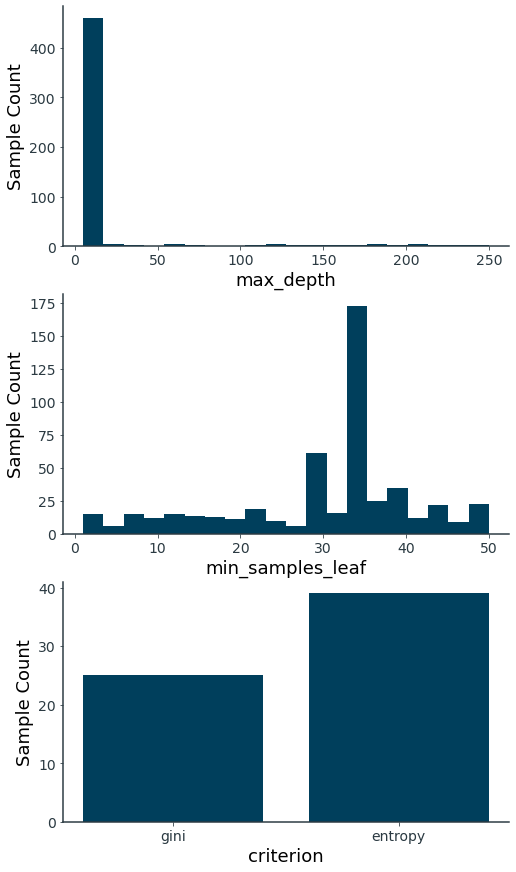

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
for i in range(3):
    plot_histogram(opt.optimizer_results_[i], 0, ax=ax[i])